# Healthcare Attrition Analysis




Due to the rate of attrition in the US Healthcare System being at an all-time high, this analysis seeks to create a machine learning model to predict employee attrition. The dataset used for the analysis is available on Kaggle[https://www.kaggle.com/datasets/jpmiller/employee-attrition-for-healthcare/data?select=watson_healthcare_modified.csv] - and was synthetically created and based on the IBM Watson dataset for attrition. 




In [55]:
import pandas as pd
import numpy as np
import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import plot_importance
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc, ConfusionMatrixDisplay
from sklearn.utils import resample

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
nurses = pd.read_csv('/Users/wileyloyd/Library/CloudStorage/GoogleDrive-wiley.loyd@empressandcrowapothecary.com/My Drive/OneDrive-Personal/Projects/Datasets/Nurse Attrition Analysis/watson_healthcare_modified.csv')

In [3]:
nurses.head()

EmployeeID  Age Attrition     BusinessTravel  DailyRate  Department  \
0     1313919   41        No      Travel_Rarely       1102  Cardiology   
1     1200302   49        No  Travel_Frequently        279   Maternity   
2     1060315   37       Yes      Travel_Rarely       1373   Maternity   
3     1272912   33        No  Travel_Frequently       1392   Maternity   
4     1414939   27        No      Travel_Rarely        591   Maternity   

   DistanceFromHome  Education EducationField  EmployeeCount  \
0                 1          2  Life Sciences              1   
1                 8          1  Life Sciences              1   
2                 2          2          Other              1   
3                 3          4  Life Sciences              1   
4                 2          1        Medical              1   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  \
0                        2  Female          94               3         2   
1                        3    Male          61               2         2   
2                        4    Male          92               2         1   
3                        4  Female          56               3         1   
4                        1    Male          40               3         1   

  JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  MonthlyRate  \
0   Nurse                4        Single           5993        19479   
1   Other                2       Married           5130        24907   
2   Nurse                3        Single           2090         2396   
3   Other                3       Married           2909        23159   
4   Nurse                2       Married           3468        16632   

   NumCompaniesWorked Over18 OverTime  PercentSalaryHike  PerformanceRating  \
0                   8      Y      Yes                 11                  3   
1                   1      Y       No                 23                  4   
2                   6      Y      Yes                 15                  3   
3                   1      Y      Yes                 11                  3   
4                   9      Y       No                 12                  3   

   RelationshipSatisfaction  StandardHours  Shift  TotalWorkingYears  \
0                         1             80      0                  8   
1                         4             80      1                 10   
2                         2             80      0                  7   
3                         3             80      0                  8   
4                         4             80      1                  6   

   TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0                      0                1               6                   4   
1                      3                3              10                   7   
2                      3                3               0                   0   
3                      3                3               8                   7   
4                      3                3               2                   2   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                        0                     5  
1                        1                     7  
2                        0                     0  
3                        3                     0  
4                        2                     2

In [4]:
nurses.drop(['EmployeeCount', 'EmployeeID'], axis=1, inplace=True)

In [5]:
len(nurses)

1676

# Exploratory Data Analysis

<AxesSubplot: >

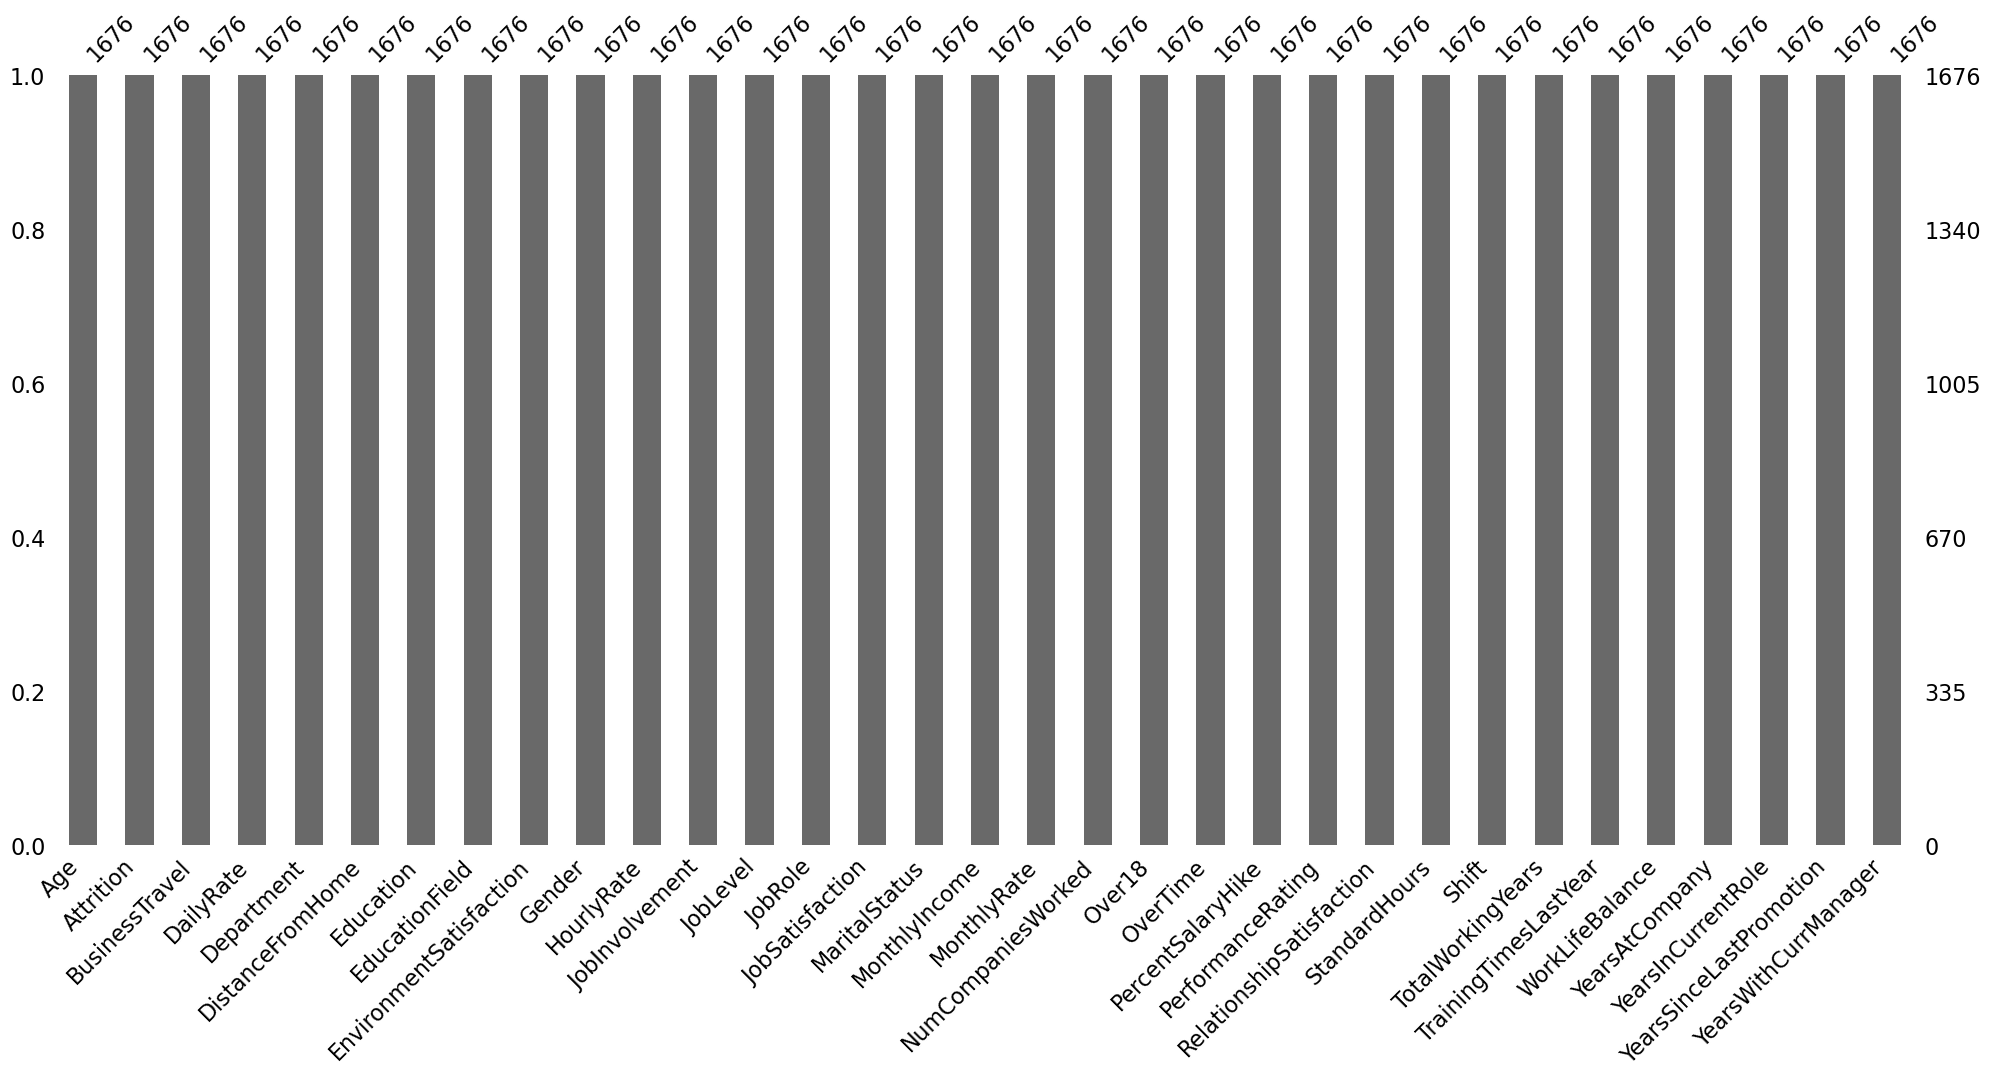

In [6]:
msno.bar(nurses)

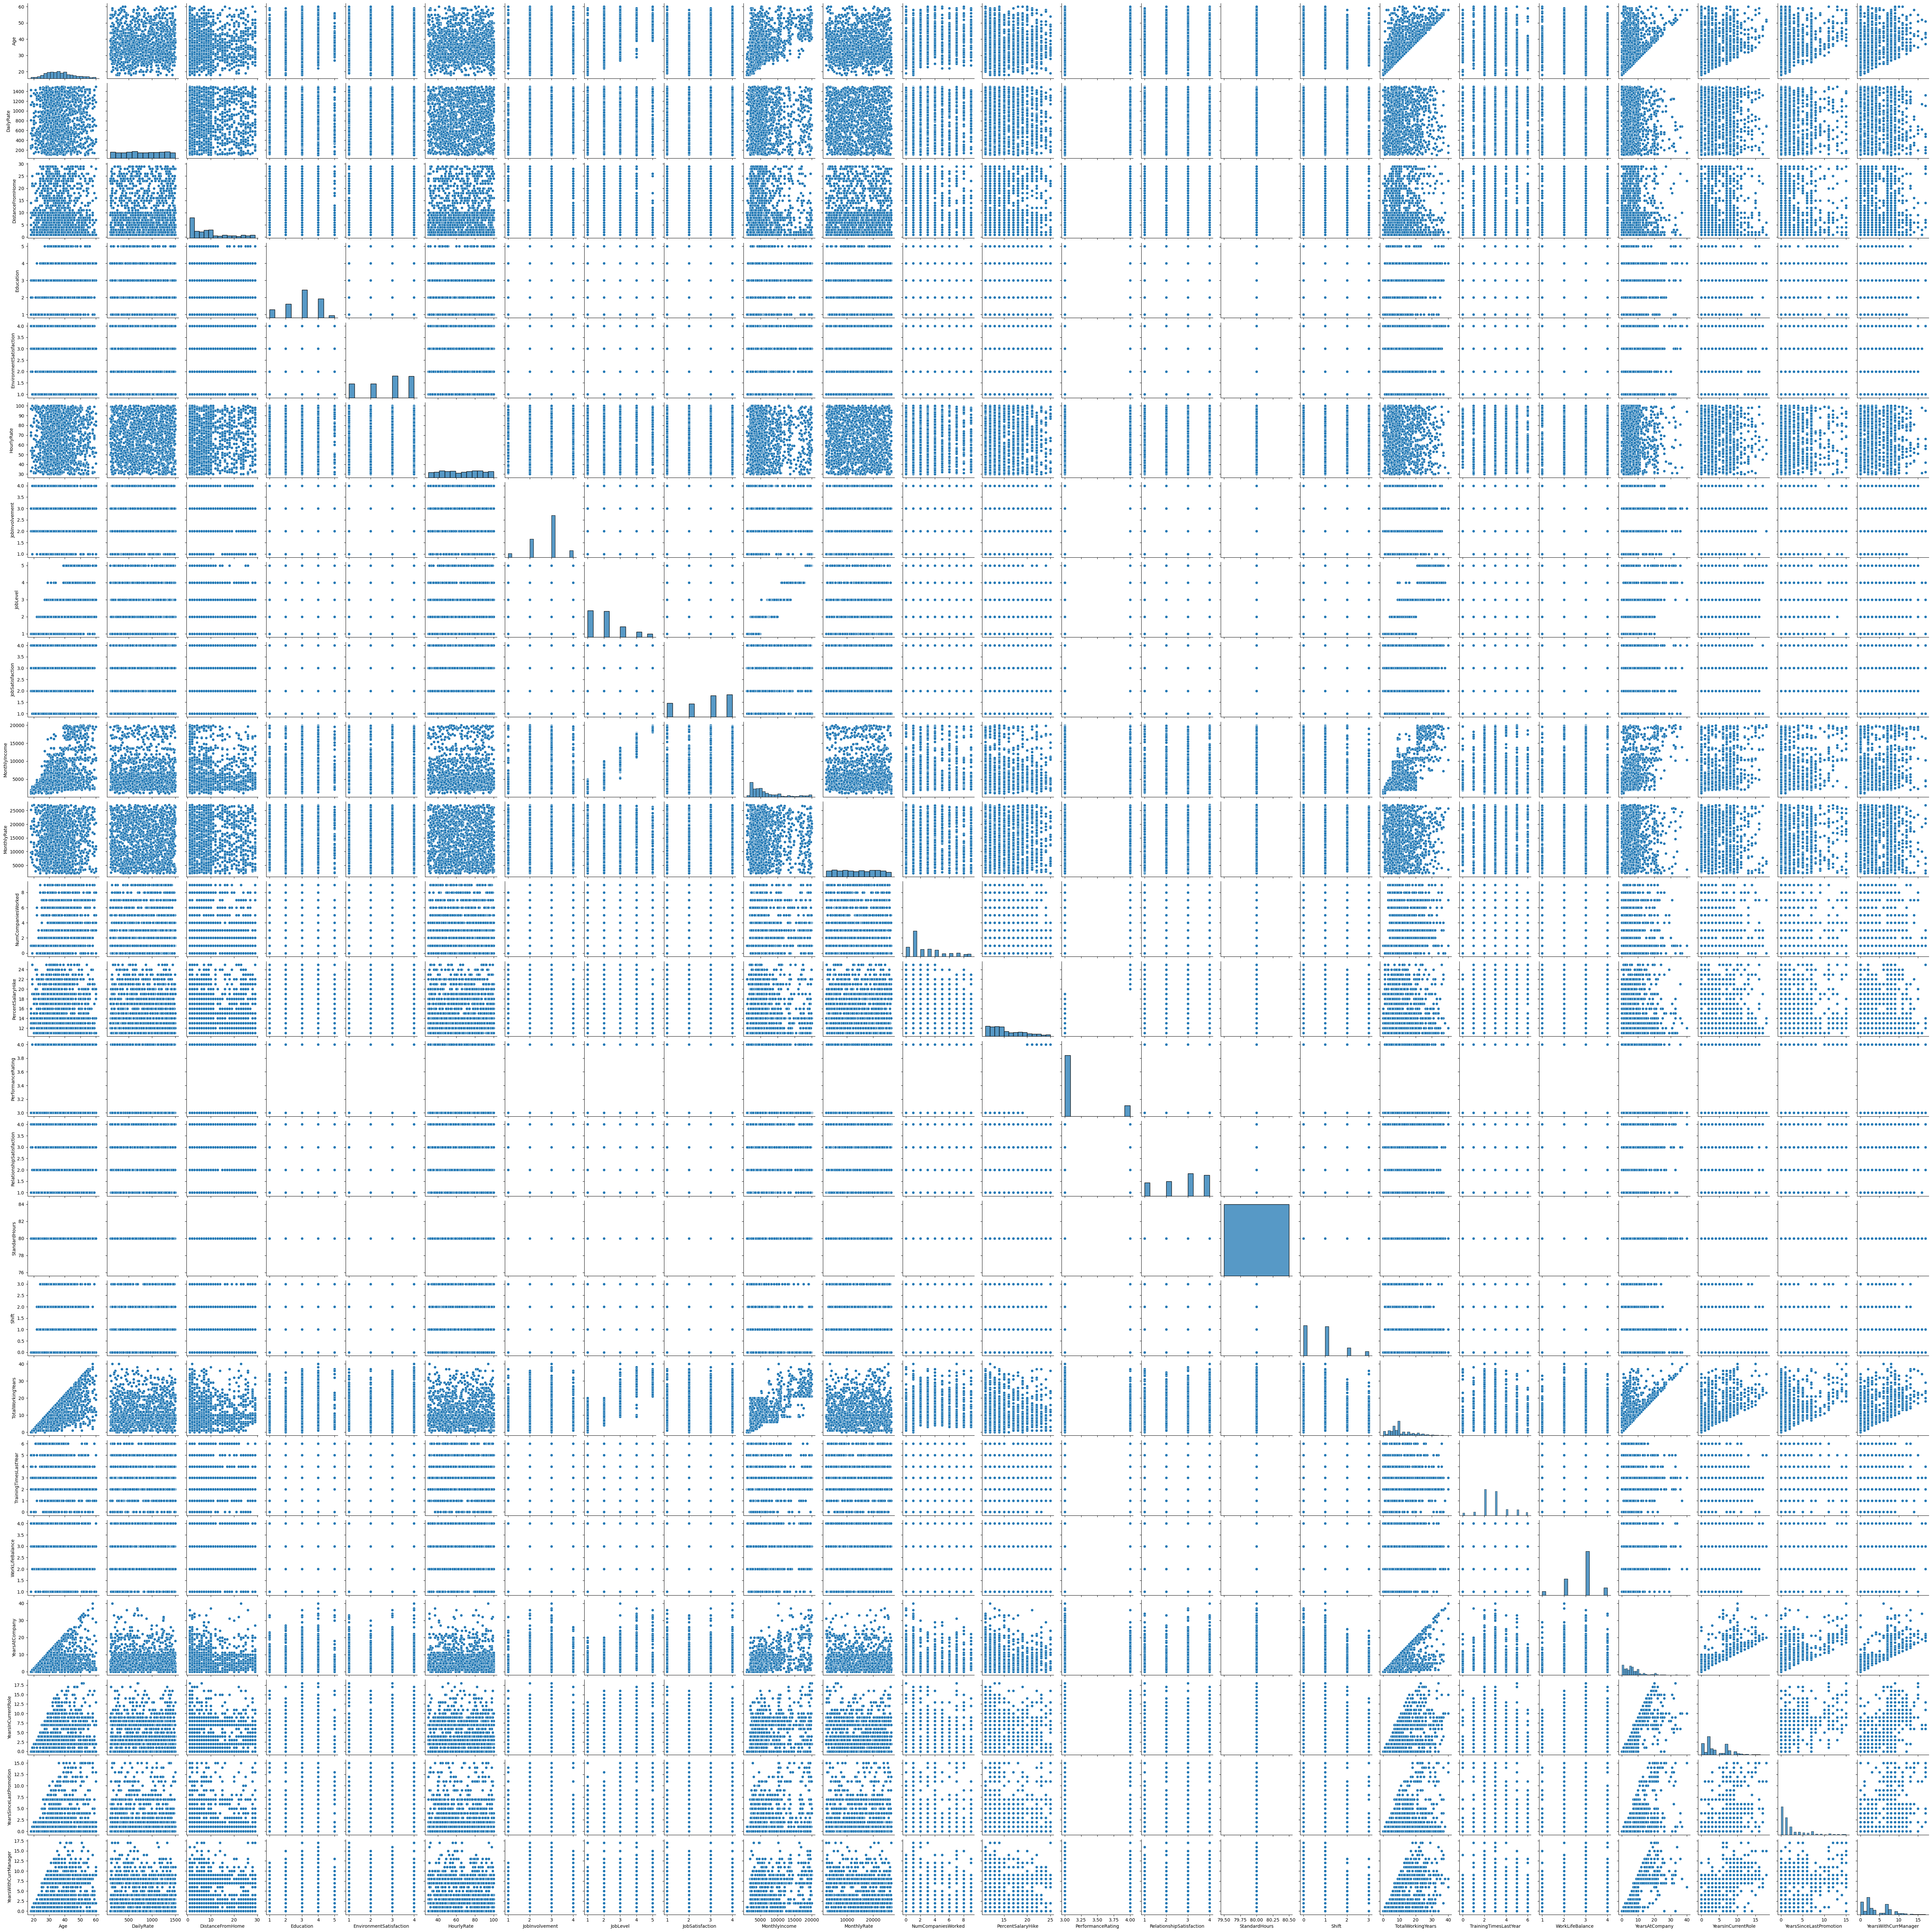

In [7]:
sns.pairplot(nurses)

In [8]:
nurses.drop(['Over18', 'StandardHours', 'PerformanceRating'], axis=1, inplace=True)

## Univariate Categorical Visualizations

Attrition is imbalanced with only 12% of the observations being 'Yes'. This can cause issues in training the model. Because this analyst is unable to gather more data, upsampling will be utilized to gain a 50/50 attrition class split.

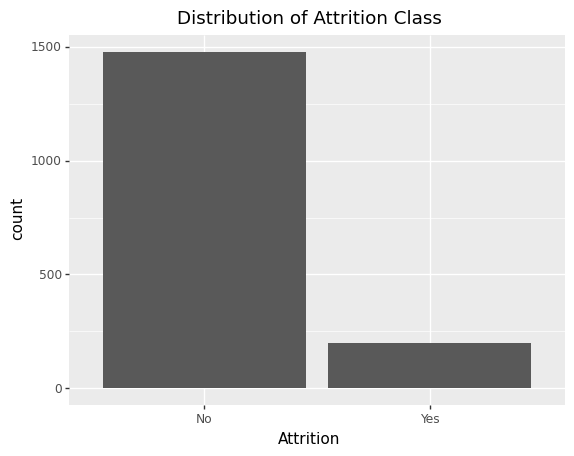

<ggplot: (8773675211813)>

In [9]:
p9.ggplot(nurses) + p9.aes(x='Attrition') + p9.geom_bar() + p9.ggtitle('Distribution of Attrition Class')

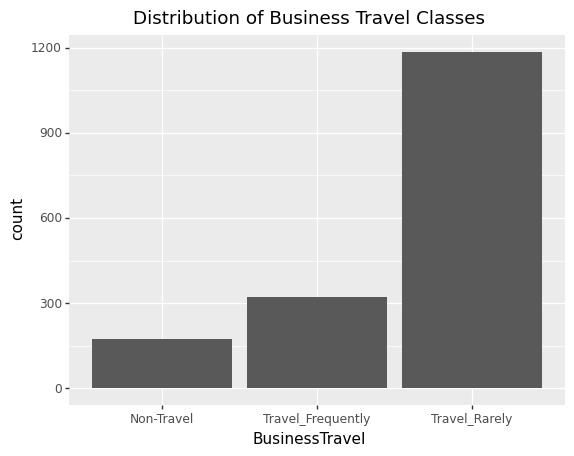

<ggplot: (8773625832509)>

In [10]:
p9.ggplot(nurses) + p9.aes(x='BusinessTravel') + p9.geom_bar() + p9.ggtitle('Distribution of Business Travel Classes')

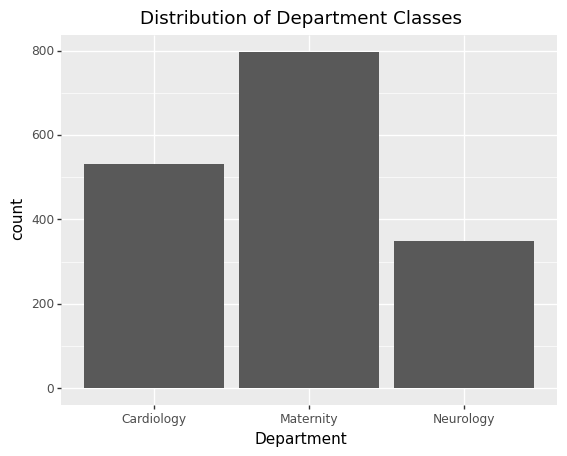

<ggplot: (8773639421859)>

In [11]:
p9.ggplot(nurses) + p9.aes(x='Department') + p9.geom_bar() + p9.ggtitle('Distribution of Department Classes')

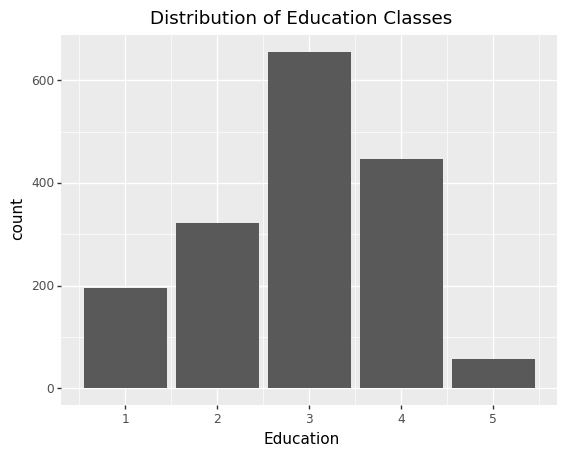

<ggplot: (8773588674952)>

In [12]:
p9.ggplot(nurses) + p9.aes(x='Education') + p9.geom_bar() + p9.ggtitle('Distribution of Education Classes')

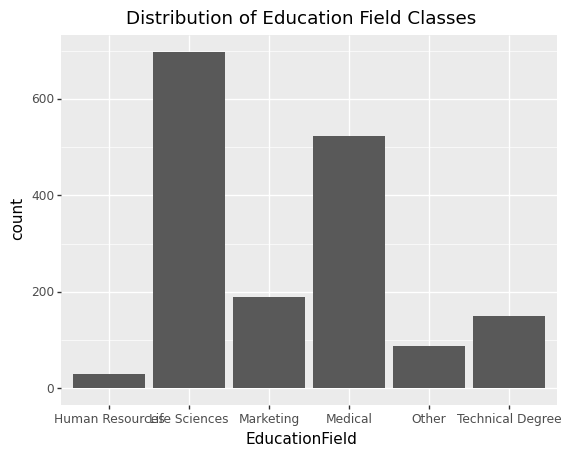

<ggplot: (8773625887994)>

In [13]:
p9.ggplot(nurses) + p9.aes(x='EducationField') + p9.geom_bar() + p9.ggtitle('Distribution of Education Field Classes')

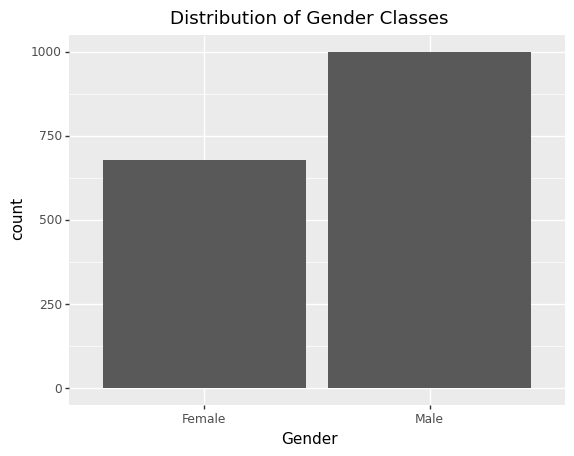

<ggplot: (8773625886314)>

In [14]:
p9.ggplot(nurses) + p9.aes(x='Gender') + p9.geom_bar() + p9.ggtitle('Distribution of Gender Classes')

While this data set was advertised as a nursing data set, it appears that there are multiple job roles within the data.

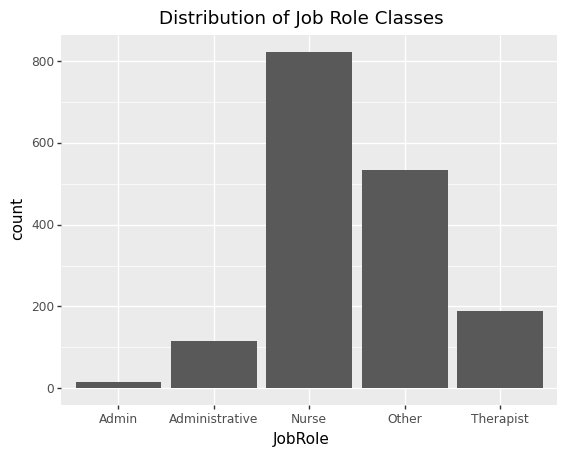

<ggplot: (8773676016493)>

In [15]:
p9.ggplot(nurses) + p9.aes(x='JobRole') + p9.geom_bar() + p9.ggtitle('Distribution of Job Role Classes')

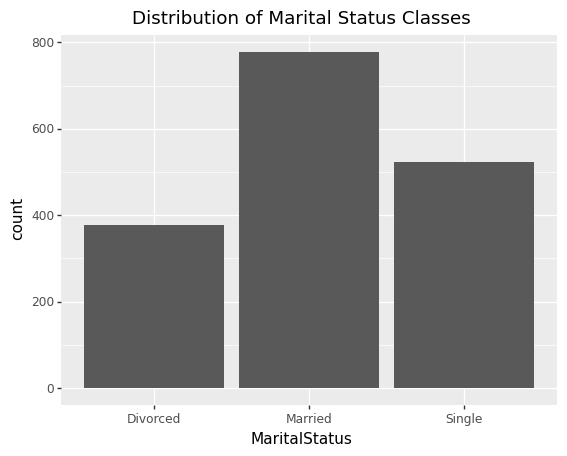

<ggplot: (8773588638615)>

In [16]:
p9.ggplot(nurses) + p9.aes(x='MaritalStatus') + p9.geom_bar() + p9.ggtitle('Distribution of Marital Status Classes')

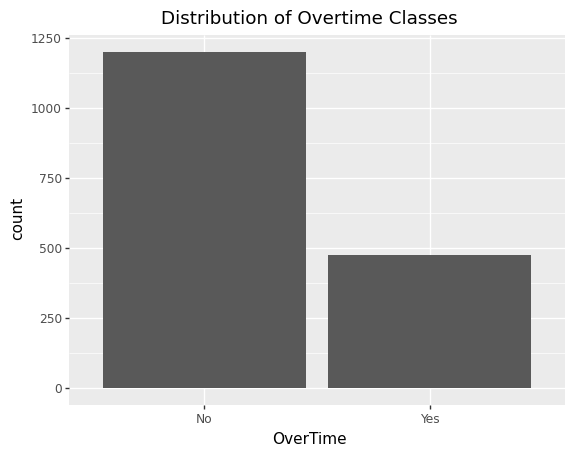

<ggplot: (8773588792567)>

In [17]:
p9.ggplot(nurses) + p9.aes(x='OverTime') + p9.geom_bar() + p9.ggtitle('Distribution of Overtime Classes')

## Univariate Integer Visualizations

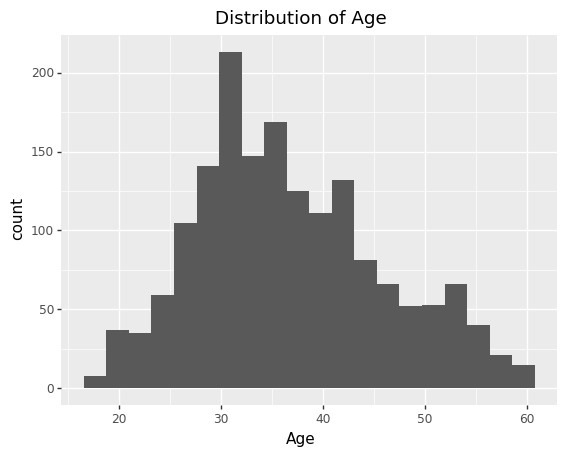

<ggplot: (8773588790700)>

In [18]:
p9.ggplot(nurses) + p9.aes(x='Age') + p9.geom_histogram() + p9.ggtitle('Distribution of Age')

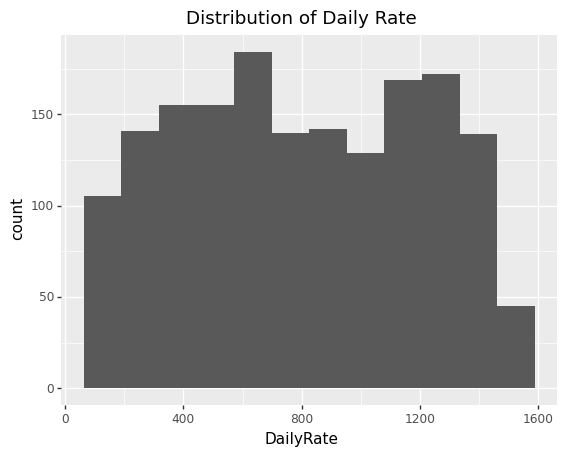

<ggplot: (8773625937065)>

In [19]:
p9.ggplot(nurses) + p9.aes(x='DailyRate') + p9.geom_histogram() + p9.ggtitle('Distribution of Daily Rate')

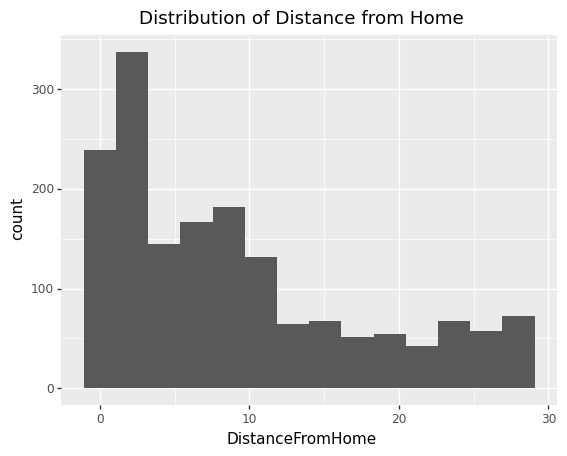

<ggplot: (8773626049871)>

In [20]:
p9.ggplot(nurses) + p9.aes(x='DistanceFromHome') + p9.geom_histogram() + p9.ggtitle('Distribution of Distance from Home')

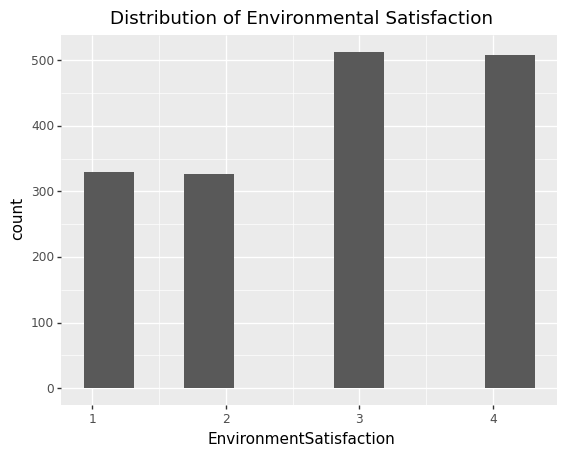

<ggplot: (8773626047305)>

In [21]:
p9.ggplot(nurses) + p9.aes(x='EnvironmentSatisfaction') + p9.geom_histogram() + p9.ggtitle('Distribution of Environmental Satisfaction')

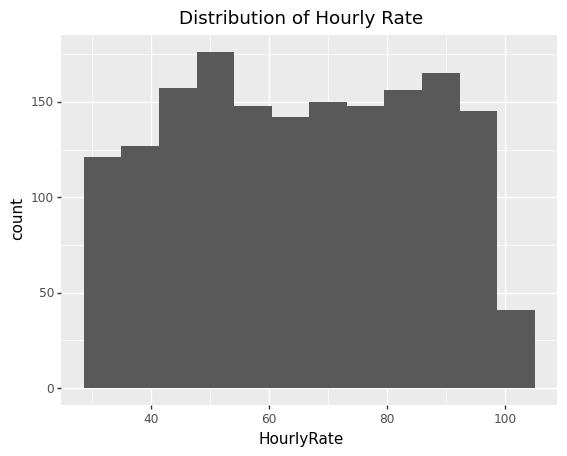

<ggplot: (8773639753981)>

In [22]:
p9.ggplot(nurses) + p9.aes(x='HourlyRate') + p9.geom_histogram() + p9.ggtitle('Distribution of Hourly Rate')

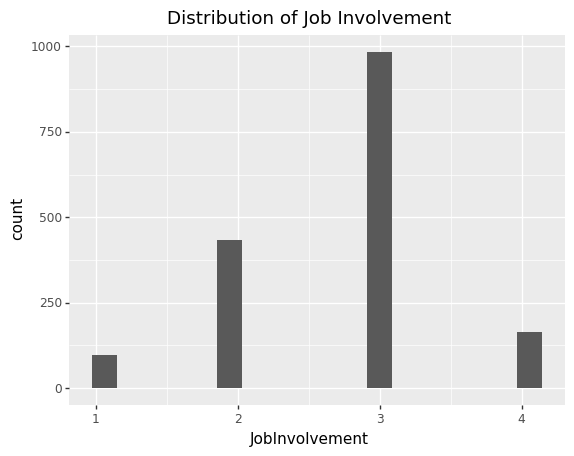

<ggplot: (8773639767899)>

In [23]:
p9.ggplot(nurses) + p9.aes(x='JobInvolvement') + p9.geom_histogram() + p9.ggtitle('Distribution of Job Involvement')

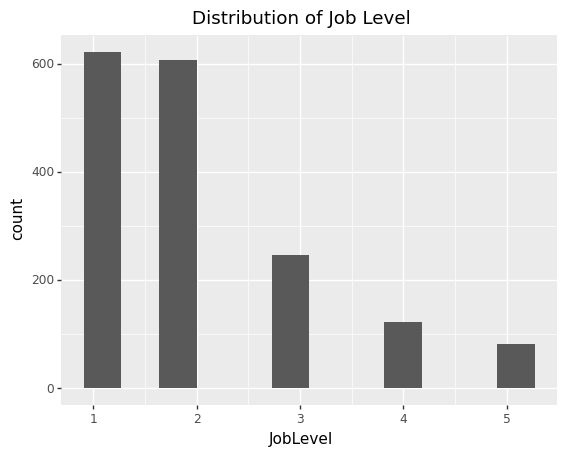

<ggplot: (8773589007168)>

In [24]:
p9.ggplot(nurses) + p9.aes(x='JobLevel') + p9.geom_histogram() + p9.ggtitle('Distribution of Job Level')

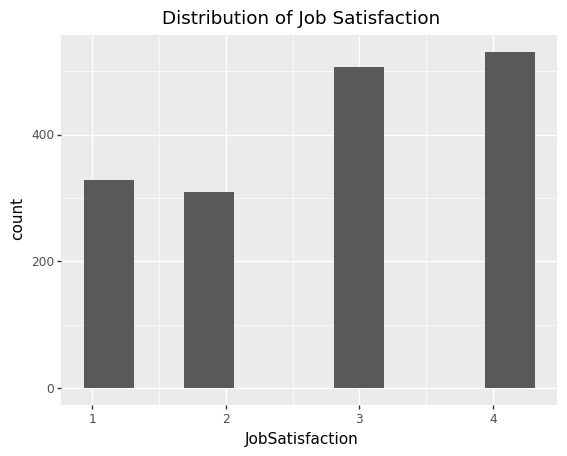

<ggplot: (8773589189422)>

In [25]:
p9.ggplot(nurses) + p9.aes(x='JobSatisfaction') + p9.geom_histogram() + p9.ggtitle('Distribution of Job Satisfaction')

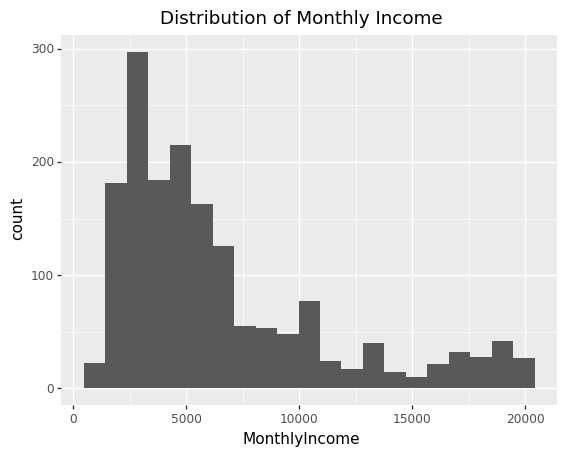

<ggplot: (8773626084861)>

In [26]:
p9.ggplot(nurses) + p9.aes(x='MonthlyIncome') + p9.geom_histogram() + p9.ggtitle('Distribution of Monthly Income')

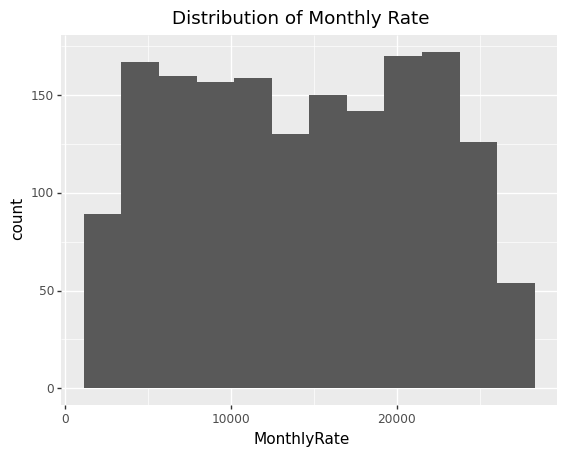

<ggplot: (8773676205213)>

In [27]:
p9.ggplot(nurses) + p9.aes(x='MonthlyRate') + p9.geom_histogram() + p9.ggtitle('Distribution of Monthly Rate')

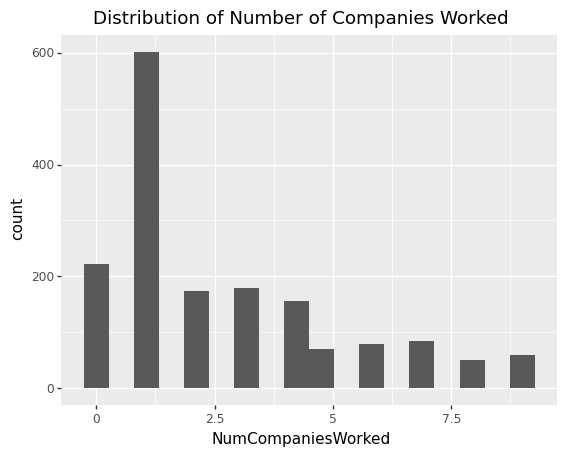

<ggplot: (8773626333537)>

In [28]:
p9.ggplot(nurses) + p9.aes(x='NumCompaniesWorked') + p9.geom_histogram() + p9.ggtitle('Distribution of Number of Companies Worked')

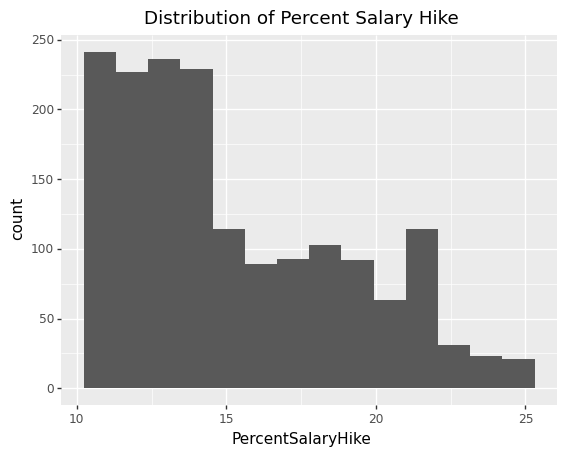

<ggplot: (8773626336100)>

In [29]:
p9.ggplot(nurses) + p9.aes(x='PercentSalaryHike') + p9.geom_histogram() + p9.ggtitle('Distribution of Percent Salary Hike')

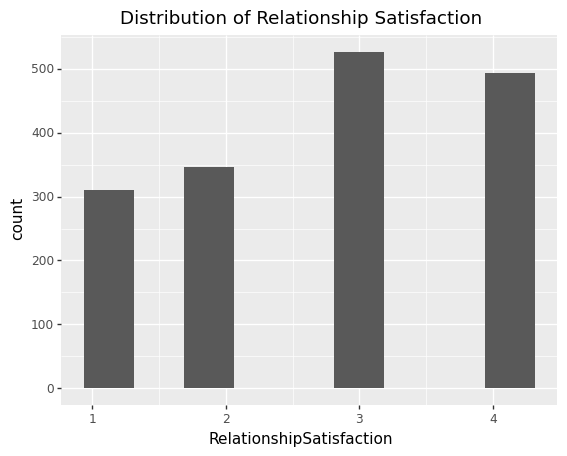

<ggplot: (8773676289687)>

In [30]:
p9.ggplot(nurses) + p9.aes(x='RelationshipSatisfaction') + p9.geom_histogram() + p9.ggtitle('Distribution of Relationship Satisfaction')

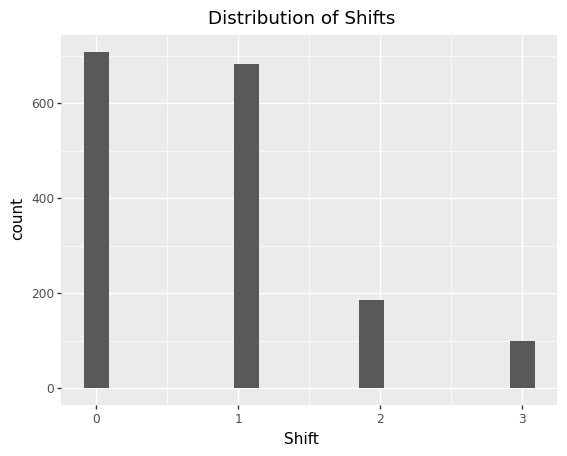

<ggplot: (8773676285709)>

In [31]:
p9.ggplot(nurses) + p9.aes(x='Shift') + p9.geom_histogram() + p9.ggtitle('Distribution of Shifts')

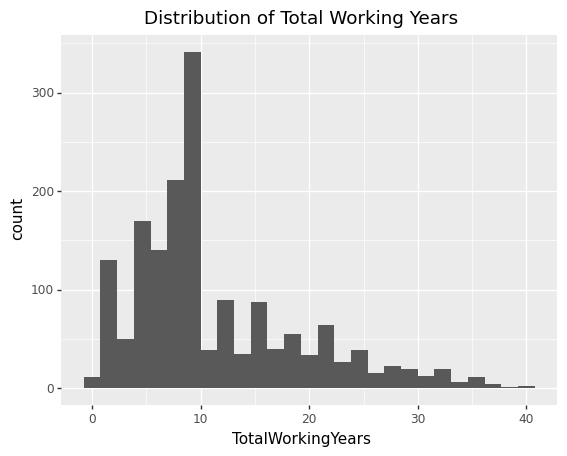

<ggplot: (8773676167153)>

In [32]:
p9.ggplot(nurses) + p9.aes(x='TotalWorkingYears') + p9.geom_histogram() + p9.ggtitle('Distribution of Total Working Years')

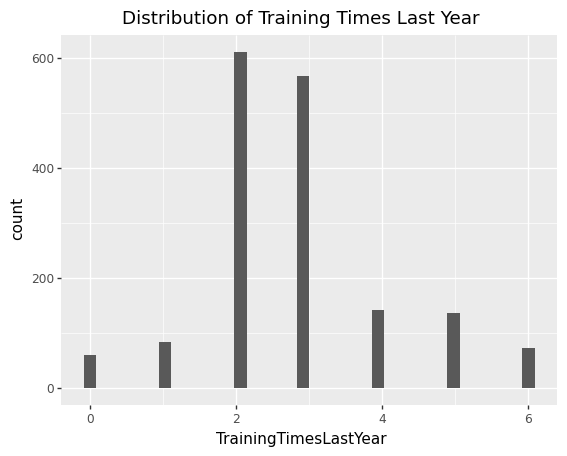

<ggplot: (8773626468615)>

In [33]:
p9.ggplot(nurses) + p9.aes(x='TrainingTimesLastYear') + p9.geom_histogram() + p9.ggtitle('Distribution of Training Times Last Year')

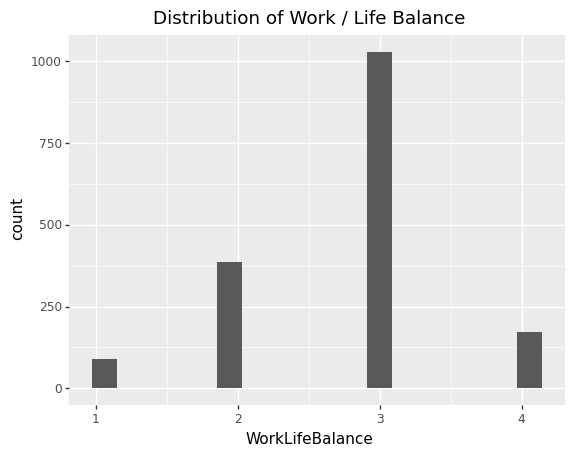

<ggplot: (8773676147170)>

In [34]:
p9.ggplot(nurses) + p9.aes(x='WorkLifeBalance') + p9.geom_histogram() + p9.ggtitle('Distribution of Work / Life Balance')

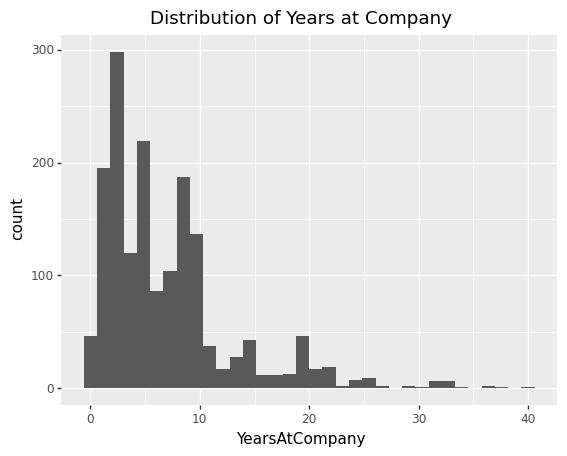

<ggplot: (8773624940662)>

In [35]:
p9.ggplot(nurses) + p9.aes(x='YearsAtCompany') + p9.geom_histogram() + p9.ggtitle('Distribution of Years at Company')

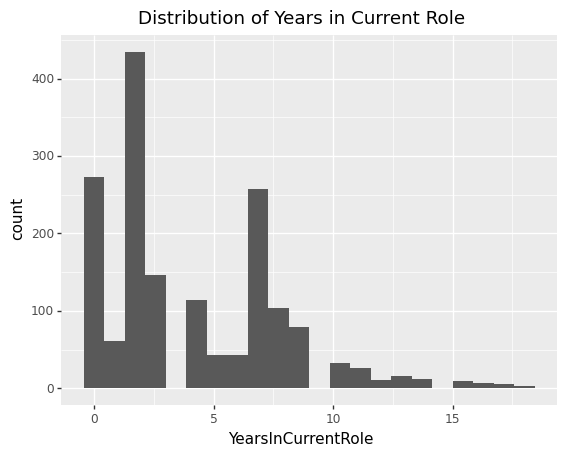

<ggplot: (8773676279821)>

In [36]:
p9.ggplot(nurses) + p9.aes(x='YearsInCurrentRole') + p9.geom_histogram() + p9.ggtitle('Distribution of Years in Current Role')

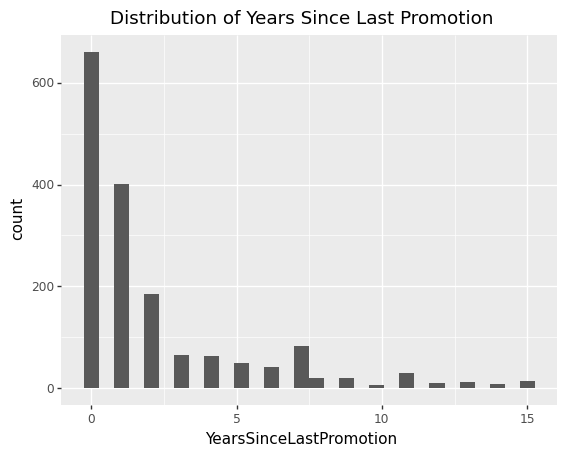

<ggplot: (8773589279034)>

In [37]:
p9.ggplot(nurses) + p9.aes(x='YearsSinceLastPromotion') + p9.geom_histogram() + p9.ggtitle('Distribution of Years Since Last Promotion')

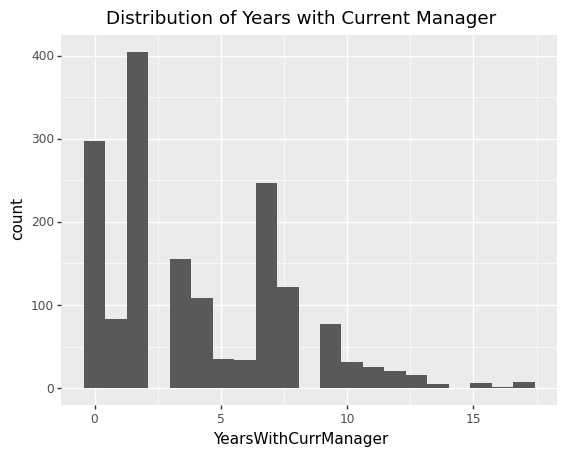

<ggplot: (8773676305661)>

In [38]:
p9.ggplot(nurses) + p9.aes(x='YearsWithCurrManager') + p9.geom_histogram() + p9.ggtitle('Distribution of Years with Current Manager')

# Converting Datatypes

In [39]:
nurses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1676 non-null   int64 
 1   Attrition                 1676 non-null   object
 2   BusinessTravel            1676 non-null   object
 3   DailyRate                 1676 non-null   int64 
 4   Department                1676 non-null   object
 5   DistanceFromHome          1676 non-null   int64 
 6   Education                 1676 non-null   int64 
 7   EducationField            1676 non-null   object
 8   EnvironmentSatisfaction   1676 non-null   int64 
 9   Gender                    1676 non-null   object
 10  HourlyRate                1676 non-null   int64 
 11  JobInvolvement            1676 non-null   int64 
 12  JobLevel                  1676 non-null   int64 
 13  JobRole                   1676 non-null   object
 14  JobSatisfaction         

In [40]:
nurses['Attrition'] = nurses['Attrition'].map({'Yes': 1, 'No': 0})

In [41]:
for column in nurses.columns:
    if nurses[column].dtype == 'object':
        nurses[column] = nurses[column].astype('category')

# Upsampling the Data

In [42]:
minority = nurses[nurses['Attrition'] == 1]
majority = nurses[nurses['Attrition'] == 0]

In [43]:
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)

In [44]:
hc = pd.concat([majority, minority_upsampled])

In [45]:
hc['Attrition'].value_counts()

0    1477
1    1477
Name: Attrition, dtype: int64

# Train / Test Split

In [46]:
X = hc.drop(['Attrition'], axis=1)
y = hc['Attrition'].astype(int)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

# Model

In [48]:
param_grid = {
    'max_depth': [10, 15, 20],
    'learning_rate': [0.01, 0.001],
    'n_estimators': [1500, 2000, 2500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    # 'lambda' : [0, 0.1, 0.2],
    'enable_categorical': [True]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=10)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

Best Hyperparameters: {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 2500, 'subsample': 1.0}


# Model Evaluation

In [49]:
gs_df = pd.DataFrame(grid_search.cv_results_)
gs_df.head().sort_values('rank_test_score', ascending = True)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       1.920177      0.040374         0.013365        0.000368   
0       1.835124      0.275270         0.013086        0.000999   
1       1.641552      0.190691         0.012559        0.001013   
4       2.166937      0.041248         0.015348        0.000608   
2       1.818608      0.022610         0.014145        0.000654   

  param_colsample_bytree param_enable_categorical param_learning_rate  \
3                    0.8                     True                0.01   
0                    0.8                     True                0.01   
1                    0.8                     True                0.01   
4                    0.8                     True                0.01   
2                    0.8                     True                0.01   

  param_max_depth param_n_estimators param_subsample  \
3              10               2000             1.0   
0              10               1500             0.8   
1              10               1500             1.0   
4              10               2500             0.8   
2              10               2000             0.8   

                                              params  split0_test_score  \
3  {'colsample_bytree': 0.8, 'enable_categorical'...           0.994551   
0  {'colsample_bytree': 0.8, 'enable_categorical'...           0.994907   
1  {'colsample_bytree': 0.8, 'enable_categorical'...           0.994623   
4  {'colsample_bytree': 0.8, 'enable_categorical'...           0.994195   
2  {'colsample_bytree': 0.8, 'enable_categorical'...           0.994338   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
3           0.998291           0.999074           0.999497           0.998779   
0           0.998718           0.998932           0.999784           0.998204   
1           0.997934           0.998932           0.999641           0.998922   
4           0.998789           0.999074           0.999784           0.998420   
2           0.998718           0.999074           0.999784           0.998348   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
3           0.986602           0.992529           0.997198           0.994972   
0           0.987249           0.993247           0.996336           0.994541   
1           0.987033           0.992888           0.997270           0.994541   
4           0.987105           0.992888           0.996121           0.994613   
2           0.987536           0.992672           0.996121           0.994613   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
3           0.997989         0.995948        0.003789                6  
0           0.997486         0.995940        0.003535                9  
1           0.997558         0.995934        0.003637               10  
4           0.997845         0.995883        0.003670               11  
2           0.997271         0.995847        0.003542               13

In [50]:
y_train_pred = best_model.predict(X_train)

In [59]:
print('Test Accuracy Score: ', accuracy_score(y_true=y_test, y_pred=predictions))
print('Train Accuracy Score: ', accuracy_score(y_train, y_train_pred))


Test Accuracy Score:  0.988155668358714
Train Accuracy Score:  0.9974608548455354


In [60]:
print('Test ROC AUC Score: ', roc_auc_score(y_true=y_test, y_score=predictions))
print('Train ROC AUC Score: ', roc_auc_score(y_train, y_train_pred))

Test ROC AUC Score:  0.9887820512820512
Train ROC AUC Score:  0.9974248927038626


In [52]:
# Best model metrics
print("Best Parameters: \n", grid_search.best_params_)
print("Best Estimator: \n", grid_search.best_estimator_)
print("Best Score: \n", grid_search.best_score_, '\n')

# Best model confusion matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, predictions), '\n')


# Training Scores
print("Training Accuracy: ", grid_search.score(X_train, y_train))
# print("Training Mean Absolute Error: \n", mean_absolute_error(y_train, y_train_pred))
# print("Training Mean Squared Error: \n", mean_squared_error(y_train, y_train_pred))
# print("Training Root Mean Squared Error: \n", mean_squared_error(y_train, y_train_pred)**(1/2), '\n')

# Testing Scores
print("Testing Accuracy: ", grid_search.score(X_test, y_test))
# print("Testing Mean Absolute Error: \n", mean_absolute_error(y_test, predictions))
# print("Testing Mean Squared Error: \n", mean_squared_error(y_test, predictions))
# print("Testing Root Mean Squared Error: \n", mean_squared_error(y_test, predictions)**(1/2))

Best Parameters: 
 {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 2500, 'subsample': 1.0}
Best Estimator: 
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best Score: 
 0.9961134378965261 

Confusion Matrix: 
 [[305   7]
 [  0 279

Training Accuracy:  0.999934798340582
Testing Accuracy:  0.9976334895689735


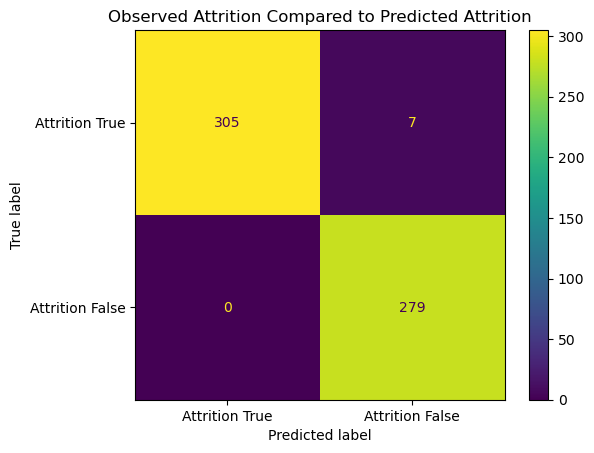

In [56]:
class_names = ['Attrition True', 'Attrition False']

cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmd.plot()
plt.title('Observed Attrition Compared to Predicted Attrition')
plt.show()

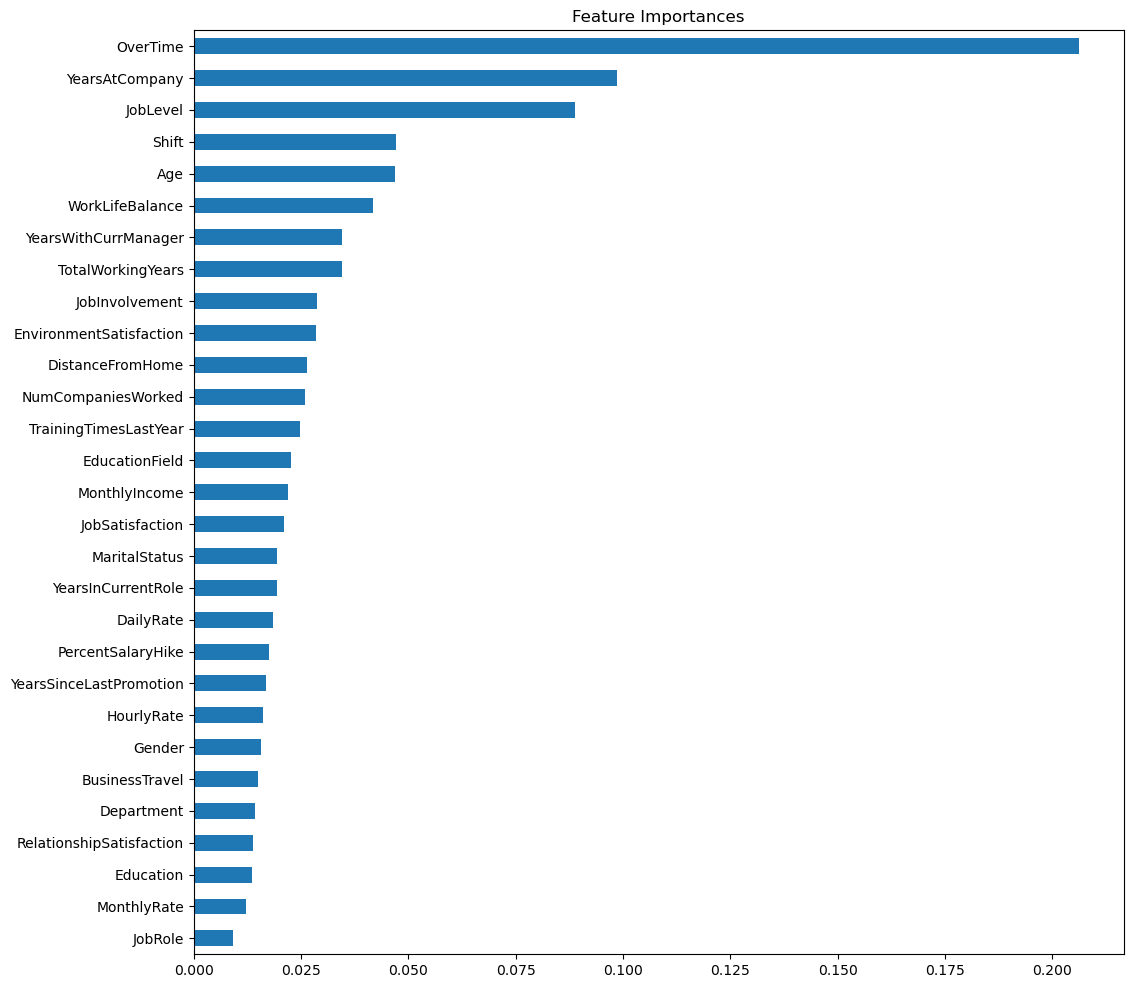

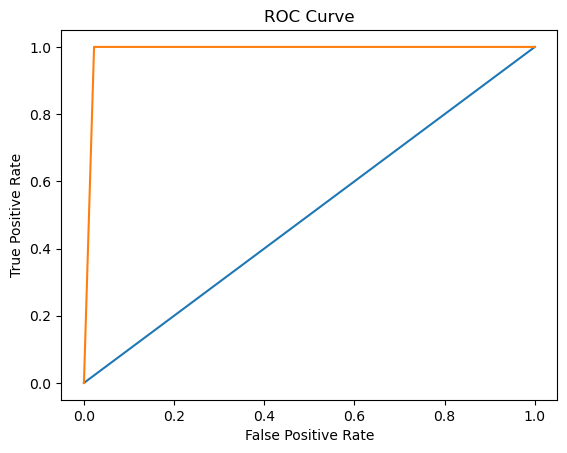

AUC:  0.9887820512820512


In [53]:
# Feature Importances
rf_importances = pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train.columns)
sorted_importances = rf_importances.sort_values()
plt.figure(figsize=(12,12))
sorted_importances.plot(kind="barh")
plt.title("Feature Importances")
plt.show()


# ROC AUC Curve
y_pred_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot([0,1], [0,1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

print("AUC: ", roc_auc_score(y_test, predictions))

In [68]:
from datetime import datetime

In [74]:
# Get the current date and time
now = datetime.now()

# Format it as 'year_month_day_hour_minute'
formatted_time = now.strftime('%Y_%m_%d_%H_%M')

# Saving the Model

In [77]:
best_model.save_model(f'/Users/wileyloyd/Library/CloudStorage/GoogleDrive-wiley.loyd@empressandcrowapothecary.com/My Drive/OneDrive-Personal/Projects/Datasets/Nurse Attrition Analysis/Healthcare_Attrition_XGB_ROCTest_{round(roc_auc_score(y_test, predictions), 2)}_ROCTrain_{round(roc_auc_score(y_train, y_train_pred), 2)}_{formatted_time}.json')

# Limitations

This analysis proposes several limitations. The dataset contains a low volume of observations, and it has a large class disparity. To overcome the large difference in attrition classes, the positive attrition observations were upsampled to match the length of the negative attrition observations to create a 50/50 split. This provides the model more examples of what a positive attrition looks like and prevents the model from simply guessing attrition for the highest score. While this solution did help the model increase accuracy and ROC, it does introduce additional bias, and is an additional limitation itself. This could cause data leakage in machine learning performance where the model is statistically not being tested on data it has never seen. While this model did achieve a high decree of accuracy and a high AUC score, these scores are likely inflated due to the statistical probability of being tested on data it has seen before.

This analysis is further limited by the data being sourced from a third-party. The full scope of how the data was aquired is unknown. While this is a synthecised dataset, the methods of creation are not clear. It's import to understand this data was created for the practice of analyzing employee attrition, and should not be applied to a real-world setting. 